In [1]:
# plot RH 
import os
os.environ['USE_PYGEOS'] = '0'
import glob
# read is2_calval
import geopandas as gpd 
import numpy as np

import glob
import time
import subprocess
import multiprocessing
from tqdm import tqdm
# read H5 file 
import h5py
########
import utm
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson
from shapely.geometry import Point

In [50]:
# remove las data files to save space.
# data_sim = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/data/las/*/*/*.las'
# # Use glob to get a list of all .las files that match the pattern
# las_files = glob.glob(data_sim)
# for f in las_files:
#     os.remove(f)

In [2]:
als_list = ['africa/csir_agincourt', # 1  epsg ---------- 32736
'africa/csir_dnyala', # 2                                 32735
'africa/csir_ireagh', #3                                  32736
'africa/csir_justicia', # 4                               32736
'africa/csir_limpopo', #5 6 7, not in sites               32736
'africa/csir_venetia', # 8, not in sites                  32735
'africa/csir_welverdient', # 9                            32736
'australia/jrsrp_ilcp2015_wholeq6'] # add 3                           28352 # GDA94 / MGA zone 52

In [9]:
# sim in valid sties
# apply filter 
valid_sites = ['amani','csir_agincourt', 'csir_dnyala', 'csir_ireagh', 'csir_justicia', 'csir_venetia', 'csir_welverdient', 'drc_ghent_field_32635', 
               'drc_ghent_field_32733', 'drc_ghent_field_32734', 'gsfc_mozambique', 'jpl_lope', 'jpl_rabi', 'tanzania_wwf_germany', 'khaoyai_thailand', 
               'chowilla', 'credo', 'karawatha', 'litchfield', 'rushworth_forests', 'tern_alice_mulga', 'tern_robson_whole', 'costarica_laselva2019', 
               'skidmore_bayerischer', 'zofin_180607', 'spain_exts1', 'spain_exts2', 'spain_exts3', 'spain_exts4', 'spain_leonposada', 'spain_leon1', 
               'spain_leon2', 'spain_leon3', 'jpl_borneo_004', 'jpl_borneo_013', 'jpl_borneo_040', 'jpl_borneo_119', 'jpl_borneo_144', 'chave_paracou', 
               'embrapa_brazil_2020_and_a01', 'embrapa_brazil_2020_bon_a01', 'embrapa_brazil_2020_cau_a01', 'embrapa_brazil_2020_duc_a01', 
               'embrapa_brazil_2020_hum_a01', 'embrapa_brazil_2020_par_a01', 'embrapa_brazil_2020_rib_a01', 'embrapa_brazil_2020_tal_a01',
               'embrapa_brazil_2020_tan_a01', 'embrapa_brazil_2020_tap_a01', 'embrapa_brazil_2020_tap_a04', 'walkerfire_20191007', 
               'neon_abby2018', 'neon_abby2019', 'neon_abby2021', 'neon_bart2018', 'neon_bart2019', 'neon_blan2019', 'neon_blan2021', 
               'neon_clbj2018', 'neon_clbj2019', 'neon_clbj2021', 'neon_clbj2021', 'neon_dela2018', 'neon_dela2019', 'neon_dela2021', 
               'neon_dsny2018', 'neon_dsny2021', 'neon_grsm2018', 'neon_grsm2021', 'neon_guan2018', 'neon_harv2018', 'neon_harv2019', 
               'neon_jerc2019', 'neon_jerc2021', 'neon_jorn2018', 'neon_jorn2019', 'neon_jorn2021', 'neon_konz2019', 'neon_konz2020', 
               'neon_leno2018', 'neon_leno2019', 'neon_leno2021', 'neon_mlbs2018', 'neon_mlbs2021', 'neon_moab2018', 'neon_moab2021', 
               'neon_niwo2019', 'neon_niwo2020', 'neon_nogp2021', 'neon_onaq2019', 'neon_onaq2021', 'neon_osbs2018', 'neon_osbs2019', 
               'neon_osbs2021', 'neon_puum2020', 'neon_rmnp2018', 'neon_rmnp2020', 'neon_scbi2019', 'neon_scbi2021', 'neon_serc2019', 
               'neon_serc2021', 'neon_sjer2019', 'neon_soap2018', 'neon_soap2019', 'neon_soap2021', 'neon_srer2019', 'neon_srer2021', 
               'neon_stei2019', 'neon_stei2020', 'neon_ster2021', 'neon_tall2018', 'neon_tall2019', 'neon_tall2021', 'neon_teak2021', 
               'neon_ukfs2018', 'neon_ukfs2019', 'neon_ukfs2020', 'neon_unde2019', 'neon_unde2020', 'neon_wood2021', 'neon_wref2019', 
               'neon_wref2021', 'neon_yell2018', 'neon_yell2019', 'neon_yell2020', 
               'neon_blan2022', 'neon_clbj2022', 'neon_grsm2022', 'neon_moab2022', 'neon_onaq2022', 'neon_rmnp2022', 'neon_serc2022', 
               'neon_stei2022', 'neon_steicheq2022', 'neon_ster2022', 'neon_unde2022', 'inpe_brazil31983', 'inpe_brazil31981', 
               'inpe_brazil31979', 'inpe_brazil31976', 'inpe_brazil31975', 'inpe_brazil31973', 'inpe_brazil31974', 'inpe_brazil31978']

# sim using UTM zones. 
# Open the file in read mode
als_list = []
file_path = '../data/all_als_project_info.txt'  # Replace with the actual path to your file
with open(file_path, 'r') as file:
    # Iterate through each line in the file
    for line in file:
        # Process each line as needed
       # if ('326' in line and 'epsg' in line):
                #print(line.strip().split()[-2])  # This example just prints each line
                als_list.append(line.strip().split()[-2])
# Convert lists to sets and find the intersection
sim_list = set(valid_sites) & set(als_list)
print('valid sites, ', len(valid_sites))
# Convert the result back to a list if needed
sim_list = list(sim_list)
len(sim_list)

valid sites,  144


142

In [2]:
import glob
#data_sim = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/' + '*/*' + '/rh_*.parquet'
data_sim = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result_simV2/' + '*/*' + '/rh_*.parquet'
files = glob.glob(data_sim)
print(len(files))

14584


In [3]:
os.path.basename(files[1])[3:-8], os.path.basename(files[1])

('ATL08_20191112135332_07130501_006_01_gt3r',
 'rh_ATL08_20191112135332_07130501_006_01_gt3r.parquet')

In [4]:
files[1].split('/')[-2]

'khaoyai_thailand'

In [10]:
# get valid sites. 
fs = []
for f in files:
    if ( f.split('/')[-2] in valid_sites):
        fs.append(f)
len(fs)

14261

In [11]:
# read test 
import pandas as pd
df= pd.read_parquet(files[1])
print(df.columns.values)
res = []
for f in fs:
    df= pd.read_parquet(f)
    res.append(df)

['rh0' 'rh1' 'rh2' 'rh3' 'rh4' 'rh5' 'rh6' 'rh7' 'rh8' 'rh9' 'rh10' 'rh11'
 'rh12' 'rh13' 'rh14' 'rh15' 'rh16' 'rh17' 'rh18' 'rh19' 'rh20' 'rh21'
 'rh22' 'rh23' 'rh24' 'rh25' 'rh26' 'rh27' 'rh28' 'rh29' 'rh30' 'rh31'
 'rh32' 'rh33' 'rh34' 'rh35' 'rh36' 'rh37' 'rh38' 'rh39' 'rh40' 'rh41'
 'rh42' 'rh43' 'rh44' 'rh45' 'rh46' 'rh47' 'rh48' 'rh49' 'rh50' 'rh51'
 'rh52' 'rh53' 'rh54' 'rh55' 'rh56' 'rh57' 'rh58' 'rh59' 'rh60' 'rh61'
 'rh62' 'rh63' 'rh64' 'rh65' 'rh66' 'rh67' 'rh68' 'rh69' 'rh70' 'rh71'
 'rh72' 'rh73' 'rh74' 'rh75' 'rh76' 'rh77' 'rh78' 'rh79' 'rh80' 'rh81'
 'rh82' 'rh83' 'rh84' 'rh85' 'rh86' 'rh87' 'rh88' 'rh89' 'rh90' 'rh91'
 'rh92' 'rh93' 'rh94' 'rh95' 'rh96' 'rh97' 'rh98' 'rh99' 'rh100'
 'h_canopy_98' 'land_segments/longitude_20m' 'land_segments/latitude_20m'
 'land_segments/delta_time']


In [12]:
# # Concatenate DataFrames along the rows (axis=0)
res_df = pd.concat(res, ignore_index=True)
#res_n_fid_df = pd.concat(res_n_fid, ignore_index=True)
len(res_df)

1804654

In [13]:
res_df.columns.values

array(['rh0', 'rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8',
       'rh9', 'rh10', 'rh11', 'rh12', 'rh13', 'rh14', 'rh15', 'rh16',
       'rh17', 'rh18', 'rh19', 'rh20', 'rh21', 'rh22', 'rh23', 'rh24',
       'rh25', 'rh26', 'rh27', 'rh28', 'rh29', 'rh30', 'rh31', 'rh32',
       'rh33', 'rh34', 'rh35', 'rh36', 'rh37', 'rh38', 'rh39', 'rh40',
       'rh41', 'rh42', 'rh43', 'rh44', 'rh45', 'rh46', 'rh47', 'rh48',
       'rh49', 'rh50', 'rh51', 'rh52', 'rh53', 'rh54', 'rh55', 'rh56',
       'rh57', 'rh58', 'rh59', 'rh60', 'rh61', 'rh62', 'rh63', 'rh64',
       'rh65', 'rh66', 'rh67', 'rh68', 'rh69', 'rh70', 'rh71', 'rh72',
       'rh73', 'rh74', 'rh75', 'rh76', 'rh77', 'rh78', 'rh79', 'rh80',
       'rh81', 'rh82', 'rh83', 'rh84', 'rh85', 'rh86', 'rh87', 'rh88',
       'rh89', 'rh90', 'rh91', 'rh92', 'rh93', 'rh94', 'rh95', 'rh96',
       'rh97', 'rh98', 'rh99', 'rh100', 'h_canopy_98',
       'land_segments/longitude_20m', 'land_segments/latitude_20m',
       'land_segments/delta

In [14]:
# read all is2 footprints.
import geopandas as gpd
gdf_is2 = gpd.read_parquet('../result/is2_20m_calval_09252023.parquet')

In [15]:
gdf_is2.columns.values

array(['land_segments/rgt', 'land_segments/segment_id_beg',
       'land_segments/segment_id_end', 'root_beam', 'root_file',
       'land_segments/canopy/h_canopy_20m', 'land_segments/latitude',
       'land_segments/longitude', 'land_segments/latitude_20m',
       'land_segments/longitude_20m', 'land_segments/delta_time',
       'geometry', 'slope'], dtype=object)

In [16]:
res_merge = pd.merge(res_df, gdf_is2, on=['land_segments/latitude_20m',
       'land_segments/longitude_20m', 'land_segments/delta_time'], how='inner')
len(res_merge)

1342421

In [17]:
print('Done!!!!!')

Done!!!!!


In [22]:
res_clean.columns.values

array(['rh0', 'rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8',
       'rh9', 'rh10', 'rh11', 'rh12', 'rh13', 'rh14', 'rh15', 'rh16',
       'rh17', 'rh18', 'rh19', 'rh20', 'rh21', 'rh22', 'rh23', 'rh24',
       'rh25', 'rh26', 'rh27', 'rh28', 'rh29', 'rh30', 'rh31', 'rh32',
       'rh33', 'rh34', 'rh35', 'rh36', 'rh37', 'rh38', 'rh39', 'rh40',
       'rh41', 'rh42', 'rh43', 'rh44', 'rh45', 'rh46', 'rh47', 'rh48',
       'rh49', 'rh50', 'rh51', 'rh52', 'rh53', 'rh54', 'rh55', 'rh56',
       'rh57', 'rh58', 'rh59', 'rh60', 'rh61', 'rh62', 'rh63', 'rh64',
       'rh65', 'rh66', 'rh67', 'rh68', 'rh69', 'rh70', 'rh71', 'rh72',
       'rh73', 'rh74', 'rh75', 'rh76', 'rh77', 'rh78', 'rh79', 'rh80',
       'rh81', 'rh82', 'rh83', 'rh84', 'rh85', 'rh86', 'rh87', 'rh88',
       'rh89', 'rh90', 'rh91', 'rh92', 'rh93', 'rh94', 'rh95', 'rh96',
       'rh97', 'rh98', 'rh99', 'rh100', 'h_canopy_98',
       'land_segments/longitude_20m', 'land_segments/latitude_20m',
       'land_segments/delta

In [36]:
# read all is2 footprints. 
gdf_is2 = gpd.read_parquet('/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/is2_20m_misha_11302023.parquet')
final_out = []
for project in als_list:
        region = project.split('/')[0]
        name   =  project.split('/')[1]
#        if region == 'australia':
        print(project)
        data_sim = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/' + project + '/rh_*.parquet'
        files = glob.glob(data_sim)
        print(len(files))
        res = []
        for f in files:
            df = pd.read_parquet(f)
            res.append(df)
        res = pd.concat(res, ignore_index=True)
        print(len(res))
        #print(res.head())
        out = gdf_is2.merge(res, on=['land_segments/latitude_20m', 'land_segments/longitude_20m', 'land_segments/delta_time'], how='right')
        #out.dropna(inplace=True)
        out['project_name'] = name
        out['region'] = region
        final_out.append(out)
        #out.plot()
                #out.to_parquet('../result/out2mi/' + name + '.parquet')
gdf_combined = gpd.GeoDataFrame( pd.concat(final_out, ignore_index=True) )
gdf_combined.to_parquet('../result/out2mi/africa_australia_20m_02242024.parquet')

africa/csir_agincourt
43
5209
africa/csir_dnyala
153
21178
africa/csir_ireagh
109
14043
africa/csir_justicia
145
15771
africa/csir_limpopo
233
17039
africa/csir_venetia
103
18457
africa/csir_welverdient
272
33633
australia/jrsrp_ilcp2015_wholeq6
555
21621


In [58]:
# Remove column 'B' in place
#gdf_combined.drop('fid', axis=1, inplace=True)
#gdf_combined.head()
gdf_combined.to_parquet('../result/out2mi/africa_australia_20m.parquet')

In [72]:
res_all_test = gpd.read_parquet('../result/is2_20m_cal_val_all_11212023.parquet')

In [73]:
print(len(res_all_test))

2113528


In [8]:
res_merge = pd.merge(res, gdf_is2, on='fid', how='inner')

In [39]:
res_clean = gdf_combined.dropna()
# .to_parquet('../result/csir_welverdient.parquet')

In [18]:
res_clean =  res_merge.dropna()

In [23]:
res_clean = res_clean.drop(columns=['geometry'])

In [11]:
#res_clean.drop('geometry', axis=1).to_parquet('../result/IS2_calval_sim_11062023.parquet')
#res_clean = pd.read_parquet('../result/IS2_calval_sim_11062023.parquet')

In [19]:
res_clean = res_clean[(res_clean['h_canopy_98'] > 1) & (res_clean['h_canopy_98'] < 120) &
                        (abs(res_clean['h_canopy_98'] -res_clean['rh98'] ) < 10) &
                         (res_clean['rh0'] < 5) &
                       (res_clean['land_segments/canopy/h_canopy_20m'] > 1) & (res_clean['land_segments/canopy/h_canopy_20m'] < 120) ]

In [20]:
res_clean['h_canopy_98'].describe()

count    954823.000000
mean         13.188537
std           8.884017
min           1.000425
25%           6.908043
50%          11.303765
75%          17.195693
max         119.747961
Name: h_canopy_98, dtype: float64

In [25]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/is2_calval


In [24]:
res_clean.to_parquet('../result/is2_calval_20241104.parquet')

In [28]:
(res_clean['land_segments/canopy/h_canopy_20m'] - res_clean['h_canopy_98']).describe()
res_clean.columns.values

array(['rh0', 'rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8',
       'rh9', 'rh10', 'rh11', 'rh12', 'rh13', 'rh14', 'rh15', 'rh16',
       'rh17', 'rh18', 'rh19', 'rh20', 'rh21', 'rh22', 'rh23', 'rh24',
       'rh25', 'rh26', 'rh27', 'rh28', 'rh29', 'rh30', 'rh31', 'rh32',
       'rh33', 'rh34', 'rh35', 'rh36', 'rh37', 'rh38', 'rh39', 'rh40',
       'rh41', 'rh42', 'rh43', 'rh44', 'rh45', 'rh46', 'rh47', 'rh48',
       'rh49', 'rh50', 'rh51', 'rh52', 'rh53', 'rh54', 'rh55', 'rh56',
       'rh57', 'rh58', 'rh59', 'rh60', 'rh61', 'rh62', 'rh63', 'rh64',
       'rh65', 'rh66', 'rh67', 'rh68', 'rh69', 'rh70', 'rh71', 'rh72',
       'rh73', 'rh74', 'rh75', 'rh76', 'rh77', 'rh78', 'rh79', 'rh80',
       'rh81', 'rh82', 'rh83', 'rh84', 'rh85', 'rh86', 'rh87', 'rh88',
       'rh89', 'rh90', 'rh91', 'rh92', 'rh93', 'rh94', 'rh95', 'rh96',
       'rh97', 'rh98', 'rh99', 'rh100', 'h_canopy_98',
       'land_segments/longitude_20m', 'land_segments/latitude_20m',
       'land_segments/delta

In [151]:
res_clean = gpd.GeoDataFrame(res_clean, geometry=res_clean['geometry'])
res_clean.to_parquet('../result/sim_res_12082023.parquet')

In [ ]:
#### add storng weak beam flag. 


In [27]:
# get r square 
import  scipy.stats
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

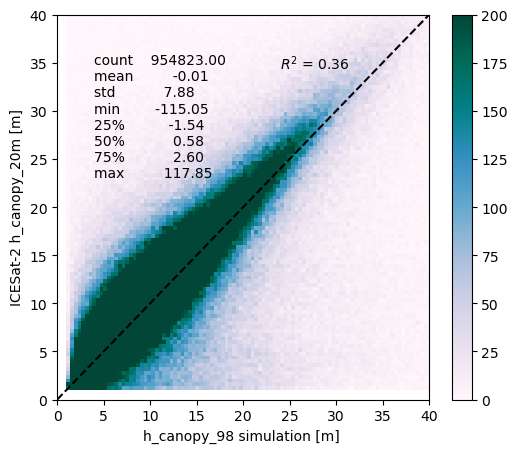

In [28]:
plt.figure(figsize=(6, 5))  # Width: 8 inches, Height: 6 inches
y = res_clean['land_segments/canopy/h_canopy_20m']
x = res_clean['h_canopy_98']
# Small bins
# Create a color map (cmap)
cmap = plt.get_cmap('PuBuGn')
plt.hist2d(x, y, bins=(300, 300), cmap=cmap, vmax = 200)
#plt.scatter(x, y, s = 1, alpha = 0.5)
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel('h_canopy_98 simulation [m] ') #
r2 = rsquared(x, y).round(2)
p = '$R^2$ = ' + str(r2)
plt.text(0.6, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.ylabel('ICESat-2 h_canopy_20m [m]')
x_values = range(41)
# Generating y values using the equation of the line: y = x
y_values = [x for x in x_values]
plt.plot(x_values, y_values, linestyle='--', label='1:1 Line', color='black')
plt.colorbar()
plt.show()

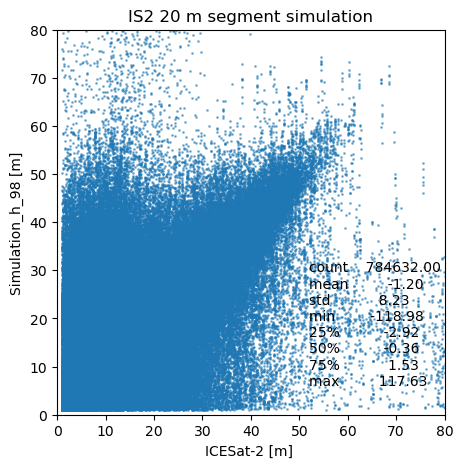

In [149]:
plt.figure(figsize=(5, 5))  # Width: 8 inches, Height: 6 inches
plt.scatter(res_clean['land_segments/canopy/h_canopy_20m'], res_clean['h_canopy_98'], s = 1, alpha = 0.5)
# Calculate summary statistics using describe()
summary_stats = (res_clean['land_segments/canopy/h_canopy_20m'] - res_clean['h_canopy_98']).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.65, 0.4, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.xlabel('ICESat-2 [m] ')
plt.ylabel('Simulation_h_98 [m]')
plt.title('IS2 20 m segment simulation')
plt.xlim(0,80)
plt.ylim(0,80)
plt.savefig('../result/is2_sim.jpeg', dpi=300)
# Show the plot
plt.show()

In [14]:
res_clean = res_clean [res_clean['land_segments/canopy/h_canopy_20m'] <=120]
res_clean = res_clean [res_clean['h_canopy_98'] <=120]


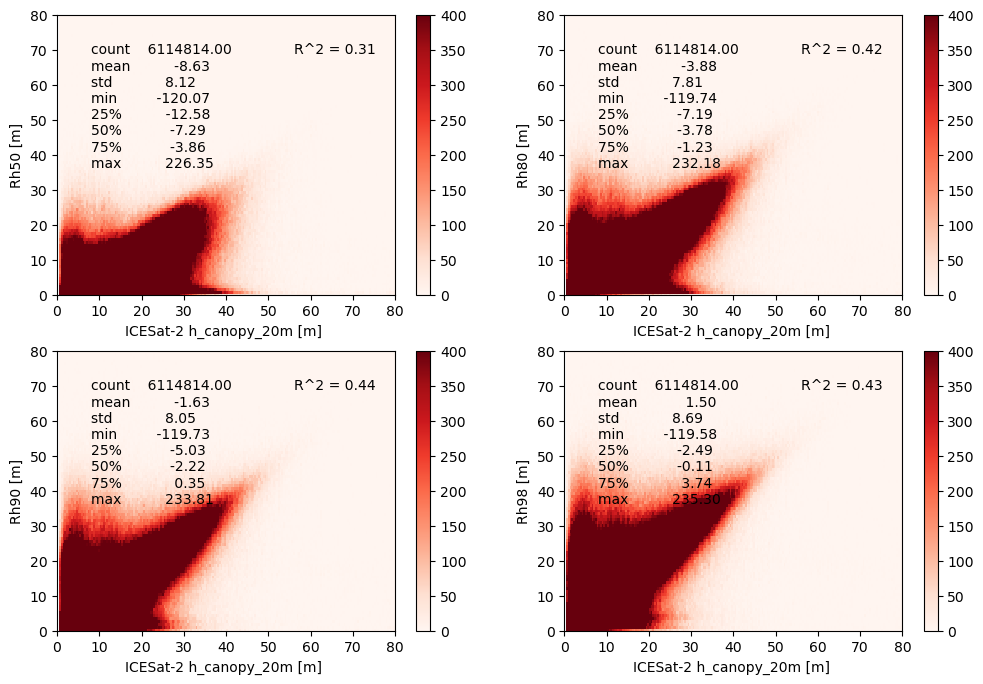

In [21]:
import seaborn as sns
plt.subplots(2, 2, figsize=(12, 8))
plt.subplot(2, 2, 1)
x = res_clean['land_segments/canopy/h_canopy_20m']
y = res_clean['rh50']
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.Reds, vmax = 400)
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel('ICESat-2 h_canopy_20m [m] ')
plt.ylabel('Rh50 [m]')
r2 = rsquared(x, y).round(2)
p = 'R^2 = ' + str(r2)
plt.text(0.7, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.colorbar()

plt.subplot(2, 2, 2)
x = res_clean['land_segments/canopy/h_canopy_20m']
y = res_clean['rh80']
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.Reds, vmax = 400)
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel('ICESat-2 h_canopy_20m [m] ')
plt.ylabel('Rh80 [m]')
r2 = rsquared(x, y).round(2)
p = 'R^2 = ' + str(r2)
plt.text(0.7, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.colorbar()

plt.subplot(2, 2, 3)
x = res_clean['land_segments/canopy/h_canopy_20m']
y = res_clean['rh90']
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.Reds, vmax = 400)
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel('ICESat-2 h_canopy_20m [m] ')
r2 = rsquared(x, y).round(2)
p = 'R^2 = ' + str(r2)
plt.text(0.7, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.ylabel('Rh90 [m]')
plt.colorbar()


plt.subplot(2, 2, 4)
x = res_clean['land_segments/canopy/h_canopy_20m']
y = res_clean['rh98']
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.Reds, vmax = 400)
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel('ICESat-2 h_canopy_20m [m] ')
r2 = rsquared(x, y).round(2)
p = 'R^2 = ' + str(r2)
plt.text(0.7, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.ylabel('Rh98 [m]')
plt.colorbar()

plt.show()

### import seaborn as sns
x = res_clean['land_segments/canopy/h_canopy_20m']
y = res_clean['h_canopy_98']
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.Reds, vmax = 400)
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel('ICESat-2 h_canopy_20m [m] ')
cor = np.corrcoef(x, y)[0, 1].round(2)
p = 'r = ' + str(cor)
plt.text(0.8, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.ylabel('Simulated h_canopy_98 [m]')
plt.colorbar()
plt.show()

In [148]:
# Calculate RMSE
rmse = np.sqrt(np.mean((y - x) ** 2))
print("RMSE:", rmse)

RMSE: 8.313848685054


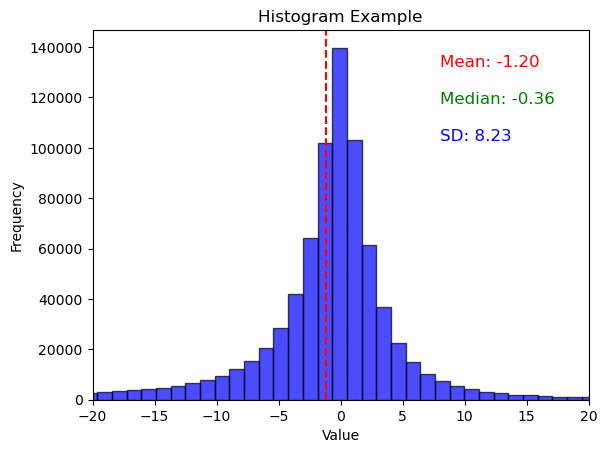

In [147]:
# Create a histogram
data = y - x
plt.hist(data, bins=200, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')
plt.xlim(-20, 20)  # Set the x-axis limits from -3 to 3
# Show the histogram
# Calculate statistics
mean = np.mean(data)
median = np.median(data)
std_dev = np.std(data)
# Add a vertical line at x=3
plt.axvline(x=mean, color='red', linestyle='--')
# Display statistics on the plot

plt.text(0.7, 0.9, f'Mean: {mean:.2f}', transform=plt.gca().transAxes, fontsize=12, color='red')
plt.text(0.7, 0.8, f'Median: {median:.2f}', transform=plt.gca().transAxes, fontsize=12, color='green')
plt.text(0.7, 0.7, f'SD: {std_dev:.2f}', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.show()

In [99]:
import fiona
res_clean.drop('geometry', axis=1).to_parquet('../result/csir_welverdient.parquet')

In [25]:
# test why > 300 20m is2 points ---> onl 40 rh metrics 
lasfile = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/data/las/seasia/jpl_borneo_119/features-3_l2d_s1c2_0000001.las'
is2file = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/seasia/jpl_borneo_119/features-3_l2d_s1c2_0000001.csv'

In [175]:
#######  add strong beam flag 
all = gpd.read_parquet('../result/is2_20m_11272023.parquet')
#sim = pd.read_parquet('../result/IS2_calval_sim_11062023.parquet')
#res_clean

array(['rh0', 'rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8',
       'rh9', 'rh10', 'rh11', 'rh12', 'rh13', 'rh14', 'rh15', 'rh16',
       'rh17', 'rh18', 'rh19', 'rh20', 'rh21', 'rh22', 'rh23', 'rh24',
       'rh25', 'rh26', 'rh27', 'rh28', 'rh29', 'rh30', 'rh31', 'rh32',
       'rh33', 'rh34', 'rh35', 'rh36', 'rh37', 'rh38', 'rh39', 'rh40',
       'rh41', 'rh42', 'rh43', 'rh44', 'rh45', 'rh46', 'rh47', 'rh48',
       'rh49', 'rh50', 'rh51', 'rh52', 'rh53', 'rh54', 'rh55', 'rh56',
       'rh57', 'rh58', 'rh59', 'rh60', 'rh61', 'rh62', 'rh63', 'rh64',
       'rh65', 'rh66', 'rh67', 'rh68', 'rh69', 'rh70', 'rh71', 'rh72',
       'rh73', 'rh74', 'rh75', 'rh76', 'rh77', 'rh78', 'rh79', 'rh80',
       'rh81', 'rh82', 'rh83', 'rh84', 'rh85', 'rh86', 'rh87', 'rh88',
       'rh89', 'rh90', 'rh91', 'rh92', 'rh93', 'rh94', 'rh95', 'rh96',
       'rh97', 'rh98', 'rh99', 'rh100', 'h_canopy_98', 'fid',
       'land_segments/rgt', 'land_segments/segment_id_beg',
       'land_segments/segment_id_end', 'root_beam', 'root_file',
       'land_segments/canopy/h_canopy_20m', 'land_segments/latitude',
       'land_segments/longitude', 'land_segments/latitude_20m',
       'land_segments/longitude_20m', 'land_segments/delta_time',
       'geometry', 'slope'], dtype=object)

array(['orbit_info/sc_orient', 'root_file', 'root_beam',
       'land_segments/delta_time', 'land_segments/terrain/h_te_best_fit',
       'land_segments/canopy/n_ca_photons', 'land_segments/night_flag',
       'land_segments/canopy/h_canopy_20m', 'land_segments/latitude',
       'land_segments/longitude', 'land_segments/latitude_20m',
       'land_segments/longitude_20m', 'geometry'], dtype=object)

In [22]:
strong = strong[['land_segments/latitude_20m', 'land_segments/longitude_20m', 'land_segments/delta_time']]

In [163]:
# List of columns to be dropped
columns_to_drop = [ 'root_beam', 'root_file',
       'land_segments/canopy/h_canopy_20m', 'land_segments/latitude',
       'land_segments/longitude', 
       'geometry']

# Drop columns from the DataFrame
df = res_clean.drop(columns=columns_to_drop)

In [176]:
# land_segments/latitude_20m	land_segments/longitude_20m	 	land_segments/delta_time
merged_df = df.merge(all, on=['land_segments/latitude_20m', 'land_segments/longitude_20m', 'land_segments/delta_time'], how='inner')

In [177]:
print(len(merged_df))
merged_df.columns.values

656182


array(['rh0', 'rh1', 'rh2', 'rh3', 'rh4', 'rh5', 'rh6', 'rh7', 'rh8',
       'rh9', 'rh10', 'rh11', 'rh12', 'rh13', 'rh14', 'rh15', 'rh16',
       'rh17', 'rh18', 'rh19', 'rh20', 'rh21', 'rh22', 'rh23', 'rh24',
       'rh25', 'rh26', 'rh27', 'rh28', 'rh29', 'rh30', 'rh31', 'rh32',
       'rh33', 'rh34', 'rh35', 'rh36', 'rh37', 'rh38', 'rh39', 'rh40',
       'rh41', 'rh42', 'rh43', 'rh44', 'rh45', 'rh46', 'rh47', 'rh48',
       'rh49', 'rh50', 'rh51', 'rh52', 'rh53', 'rh54', 'rh55', 'rh56',
       'rh57', 'rh58', 'rh59', 'rh60', 'rh61', 'rh62', 'rh63', 'rh64',
       'rh65', 'rh66', 'rh67', 'rh68', 'rh69', 'rh70', 'rh71', 'rh72',
       'rh73', 'rh74', 'rh75', 'rh76', 'rh77', 'rh78', 'rh79', 'rh80',
       'rh81', 'rh82', 'rh83', 'rh84', 'rh85', 'rh86', 'rh87', 'rh88',
       'rh89', 'rh90', 'rh91', 'rh92', 'rh93', 'rh94', 'rh95', 'rh96',
       'rh97', 'rh98', 'rh99', 'rh100', 'h_canopy_98', 'fid',
       'land_segments/rgt', 'land_segments/segment_id_beg',
       'land_segments/segmen

In [26]:
#### add strong beam flag 
print('## -- select strong beams')
gdf = merged_df
gdf['strong_flag'] = ((gdf['root_beam'].isin(['gt1r', 'gt2r', 'gt3r'])) & (gdf['orbit_info/sc_orient'] == 1)) | \
                 ((gdf['root_beam'].isin(['gt1l', 'gt2l', 'gt3l'])) & (gdf['orbit_info/sc_orient'] == 0))

gdf_strong = gdf[gdf['strong_flag'] == True]
gdf_weak= gdf[gdf['strong_flag'] == False]

## -- select strong beams


KeyError: 'orbit_info/sc_orient'

In [35]:
#merged_df.to_parquet('../result/sim_is2_20m_cal_val_strong_beam_11062023.parquet')
#df = pd.read_parquet('../result/sim_is2_20m_cal_val_strong_beam_11062023.parquet')

ValueError: autodetected range of [nan, nan] is not finite

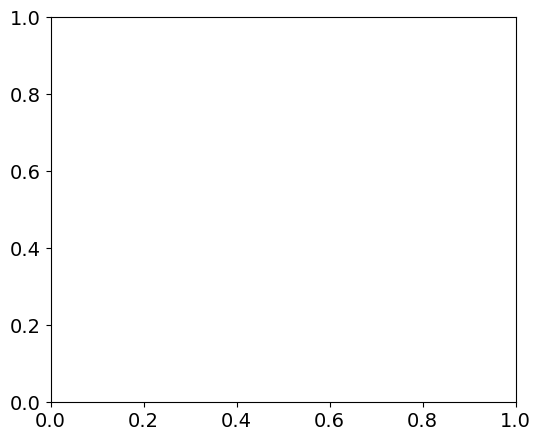

In [38]:
plt.figure(figsize=(6, 5))  # Width: 8 inches, Height: 6 inches
y = gdf_combined['land_segments/canopy/h_canopy_20m']
x = gdf_combined['rh98']
import matplotlib.pyplot as plt
# Set font size for all elements in Matplotlib
plt.rcParams.update({'font.size': 14})
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.Reds, vmax = 100)
#plt.scatter(x, y, s=0.5)
plt.xlim(0,80)
plt.ylim(0,80)
plt.xlabel('ALS RH98 simulation [m]')
r2 = rsquared(x, y).round(2)
p = '$R^2$ = ' + str(r2)
plt.text(0.7, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
Count= str(int(summary_stats.iloc[0]))
Mean= str(summary_stats.iloc[1])
STD=str(summary_stats.iloc[2])
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, f'Count: {Count}', transform=plt.gca().transAxes, fontsize=10, va='top')
plt.text(0.1, 0.85, f'Mean: {Mean}', transform=plt.gca().transAxes, fontsize=10, va='top')
plt.text(0.1, 0.80, f'STD: {STD}', transform=plt.gca().transAxes, fontsize=10, va='top')
plt.ylabel('ICESat-2 h_canopy_20m [m]')
plt.savefig('../result/is2_sim_all.jpeg', dpi=300)
plt.colorbar()
plt.show()

In [192]:
summary_stats.iloc[2]

7.33

In [1]:
# get site list
# > 5k strong shots. 
als_list = ['africa/csir_agincourt',
'africa/csir_dnyala',
'africa/csir_ireagh',
'africa/csir_justicia',
'africa/csir_limpopo',
'africa/csir_venetia',
'africa/csir_welverdient',
'australia/jrsrp_ilcp2015_wholeq5',
'australia/jrsrp_ilcp2015_wholeq6',
'australia/litchfield']

In [4]:
'africa/csir_agincourt' in als_list

True

In [104]:
data_sim = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/*/*/rh_*.parquet'
files = glob.glob(data_sim)
print(len(files))

81342


In [105]:
import re
re.compile(r'result/(.*?)/rh').search(files[1]).group(1)

'europe/spain_extremadura'

In [106]:
res = []
for f in files:
    name = re.compile(r'result/(.*?)/rh').search(f).group(1)
    if ( name in als_list):
        df = pd.read_parquet(f) # 
        df['ALS_Project'] = name 
        res.append(df)
res = pd.concat(res, ignore_index=True)

In [107]:
res_merge = pd.merge(res, gdf_is2, on='fid', how='inner')

In [108]:
res_merge['ALS_Project']

0        australia/litchfield
1        australia/litchfield
2        australia/litchfield
3        australia/litchfield
4        australia/litchfield
                 ...         
39700      africa/csir_dnyala
39701      africa/csir_dnyala
39702      africa/csir_dnyala
39703      africa/csir_dnyala
39704      africa/csir_dnyala
Name: ALS_Project, Length: 39705, dtype: object

In [91]:
for pro in als_list:
    result = res_merge[res_merge['ALS_Project'] == pro]
    if not result.empty:
        print('in file:', pro )
    else:
        print('not in file:', pro)

in file: africa/csir_agincourt
in file: africa/csir_dnyala
in file: africa/csir_ireagh
in file: africa/csir_justicia
not in file: africa/csir_limpopo
not in file: africa/csir_venetia
in file: africa/csir_welverdient
not in file: australia/jrsrp_ilcp2015_wholeq5
not in file: australia/jrsrp_ilcp2015_wholeq6
in file: australia/litchfield


In [93]:
strong = gpd.read_parquet('../result/is2_20m_cal_val_strong_beam_11212023.parquet')

In [94]:
strong['geometry']

h3_12_20m
8c12666d678ebff    POINT (-106.98084 58.42475)
8c12666d67aadff    POINT (-106.98067 58.42565)
8c12666d67b35ff    POINT (-106.98379 58.42588)
8c12666d642cbff    POINT (-106.98481 58.43125)
8c12666d6556bff    POINT (-106.98499 58.43214)
                              ...             
8c457664b6433ff     POINT (-90.42388 20.19854)
8c457664b64cbff     POINT (-90.42477 20.19864)
8c457664b6683ff     POINT (-90.42524 20.19810)
8c457664b6493ff     POINT (-90.42487 20.19954)
8c45729a5932dff     POINT (-90.42515 20.19901)
Name: geometry, Length: 13813129, dtype: geometry

In [109]:
strong = strong[['land_segments/latitude_20m', 'land_segments/longitude_20m', 'land_segments/delta_time']]
strong['strong_flag'] = 1

In [135]:
res_strong = strong.merge(res_merge, on=['land_segments/latitude_20m', 'land_segments/longitude_20m', 'land_segments/delta_time'], how='right')

In [140]:
res_strong['strong_flag'].describe()

count    39603.000000
mean         0.824609
std          0.380306
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: strong_flag, dtype: float64

In [138]:
res_strong['strong_flag'].fillna(0, inplace=True)
res_strong.dropna(inplace=True)
res_s_only = res_strong[res_strong['strong_flag'] > 0 ]

In [141]:
res_s_only['strong_flag']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
39700    1.0
39701    1.0
39702    1.0
39703    1.0
39704    1.0
Name: strong_flag, Length: 32657, dtype: float64

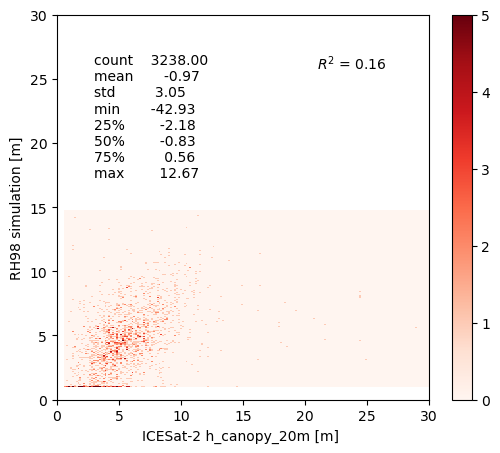

In [19]:
plt.figure(figsize=(6, 5))  # Width: 8 inches, Height: 6 inches
x = csir_agincourt['land_segments/canopy/h_canopy_20m']
y =csir_agincourt['rh98']
#plt.scatter(x,y, s=1)
# Small bins
plt.hist2d(x, y, bins=(300, 300), cmap=plt.cm.Reds, vmax = 5)
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('ICESat-2 h_canopy_20m [m] ')
r2 = rsquared(x, y).round(2)
p = '$R^2$ = ' + str(r2)
plt.text(0.7, 0.9, p, transform=plt.gca().transAxes, fontsize=10, va='top')
summary_stats = (y - x).describe().round(2)
# Convert the summary statistics to a text format
summary_text = summary_stats.to_string()
# Add the summary statistics as text to the plot
plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, va='top')
plt.ylabel('RH98 simulation [m]')
plt.colorbar()
plt.show()

In [62]:
gdf = gpd.GeoDataFrame(res_clean, geometry=res_clean['geometry'], crs="EPSG:4326")
gdf.to_parquet('../result/sim_is2_20m_sites_Mikhail.parquet')  

In [81]:
data_test = '/gpfs/data1/vclgp/xiongl/ProjectIS2CalVal/result/is2_20m_cal_val_all_11212023/*.parquet'
files = glob.glob(data_test)
print(len(files))

296


In [83]:
res = []
for f in files:
        df = gpd.read_parquet(f) # 
        res.append(df)
res = pd.concat(res, ignore_index=True)

In [37]:
gdf_combined

,orbit_info/sc_orient,root_file,root_beam,land_segments/delta_time,land_segments/terrain/h_te_best_fit,land_segments/canopy/n_ca_photons,land_segments/night_flag,land_segments/solar_elevation,land_segments/canopy/h_canopy_uncertainty,land_segments/terrain/h_te_median,...,rh94,rh95,rh96,rh97,rh98,rh99,rh100,h_canopy_98,project_name,region
0,1,ATL08_20210427171850_05171114_006_02.h5,gt3l,1.047792e+08,575.633179,11,1,-25.223478,3.402823e+38,575.760071,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.113596,1.091324,csir_agincourt,africa
1,1,ATL08_20210427171850_05171114_006_02.h5,gt3l,1.047792e+08,567.200317,13,1,-25.223375,3.402823e+38,568.164185,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.565867,2.514549,csir_agincourt,africa
2,0,ATL08_20201028015906_05170914_006_01.h5,gt1l,8.908558e+07,561.618042,19,1,-15.961705,7.977330e+00,562.706604,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.017100,1.976758,csir_agincourt,africa
3,0,ATL08_20201028015906_05170914_006_01.h5,gt1l,8.908558e+07,561.618042,19,1,-15.961705,7.977330e+00,562.706604,...,1.000000,1.316566,1.386087,1.496572,1.880729,2.427767,3.037229,2.964987,csir_agincourt,africa
4,1,ATL08_20210427171850_05171114_006_02.h5,gt3r,1.047792e+08,560.254089,53,1,-25.225290,8.472359e+00,561.368347,...,1.000000,1.000000,1.150586,1.178462,1.278390,1.314318,1.426426,1.413355,csir_agincourt,africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146946,0,ATL08_20230322121250_00171908_006_01.h5,gt1r,1.647228e+08,530.227661,10,1,-52.320141,2.165488e+01,530.393555,...,9.365250,9.641288,9.949850,10.765958,10.978027,11.138403,13.526652,11.021837,jrsrp_ilcp2015_wholeq6,australia
146947,0,ATL08_20211223095330_00171408_006_01.h5,gt1r,1.254888e+08,502.283630,14,1,-12.382792,2.571225e+01,502.663849,...,5.272936,5.833929,7.773800,9.482801,9.945225,10.490445,12.807993,10.574474,jrsrp_ilcp2015_wholeq6,australia
146948,0,ATL08_20211223095330_00171408_006_01.h5,gt1r,1.254888e+08,502.283630,14,1,-12.382792,2.571225e+01,502.663849,...,11.973384,12.492070,12.649446,13.331220,13.772926,13.812599,14.011613,13.814690,jrsrp_ilcp2015_wholeq6,australia
146949,0,ATL08_20211223095330_00171408_006_01.h5,gt1r,1.254888e+08,504.167297,13,1,-12.383323,3.144683e+01,504.744507,...,10.057170,10.534628,10.690995,10.877593,11.186328,11.834548,12.818326,11.803052,jrsrp_ilcp2015_wholeq6,australia
